In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import sys
import shutil

import fdint
import warnings
from scipy.integrate import quad
from scipy import optimize


%matplotlib inline

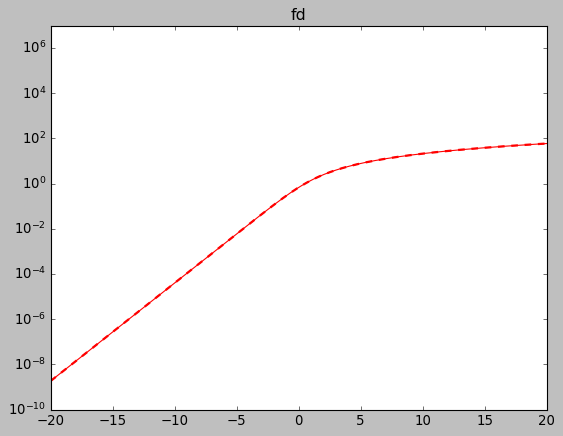

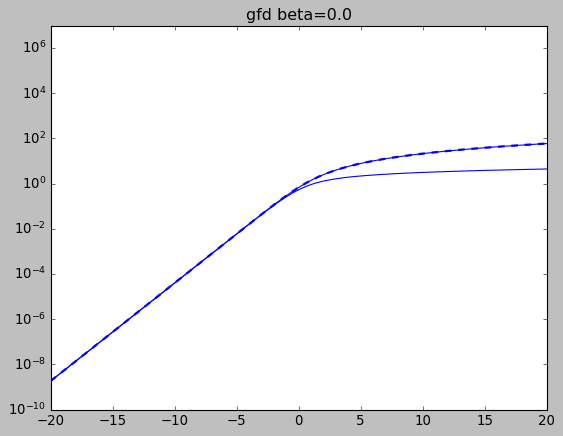

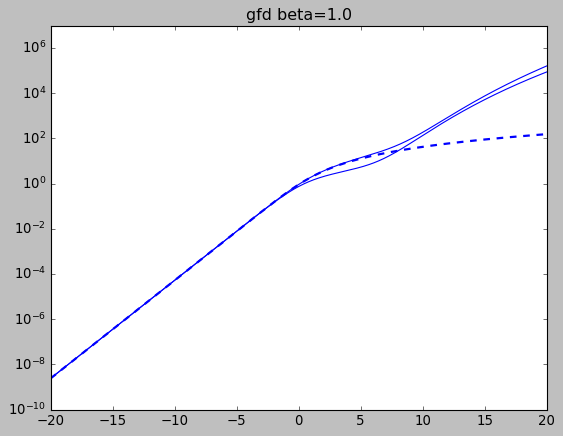

In [2]:
# Copyright (c) 2015, Scott J Maddox. All rights reserved.
# Use of this source code is governed by the BSD-3-Clause
# license that can be found in the LICENSE file.

# copied from examples/plot.py
'''
Uses numerical integration to calculate accurate values to compare against.
'''

def quad_fdk(k, phi):
    r = quad(lambda x: (x)**(k)/(1.+np.exp(x-phi)),
            0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    return r[0], r[1]

def quad_gfdk(k, phi, beta):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        def func(x):
            return (x)**(k)*np.sqrt(1+beta*x/2.)/(1.+np.exp(x-phi))
    r = quad(func, 0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    return r[0], r[1]


phi = np.linspace(-20,20,1000)

###########
# Plot fd #
###########
def plot_fd_and_dfd():
    fig, ax1 = plt.subplots()
    prefix='fd'
    ax1.set_title(prefix)
    #for k2 in range(-9,22,2):
    for k2 in [1]:
        k = k2/2.
        k2s = str(k2).replace('-','m')
        
        if k2 > -3:
            quad_vals = [quad_fdk(k, x)[0] for x in phi]
            ax1.plot(phi, quad_vals, 'r--', lw=2) # numerically integrated
          
        func = getattr(fdint,'{prefix}{k2s}h'.format(prefix=prefix,k2s=k2s))
        vals = [func(x) for x in phi]
        ax1.plot(phi, vals, 'r-') #fdint
        ''' 
        if k2 > -9:
            func = getattr(fdint,'d{prefix}{k2s}h'.format(prefix=prefix,k2s=k2s))
            vals = [func(x) for x in phi]
            ax1.plot(phi, vals, 'b-') #first derivative
        '''
    ax1.set_yscale('log')
    ax1.set_ylim(1.e-10,1.e7)
    plt.savefig("./resources/test_fermi_dirac_theta=0.png")
    
def plot_gfd_and_dgfd(beta):
    fig, ax1 = plt.subplots()
    prefix='gfd'
    ax1.set_title(prefix+' beta='+str(beta))
    #for k2 in range(-1,6,2):
    for k2 in [1]:
        k = k2/2.
        k2s = str(k2).replace('-','m')
        
        quad_vals = [quad_gfdk(k, x, beta)[0] for x in phi]
        ax1.plot(phi, quad_vals, 'b--', lw=2)
        
        func = getattr(fdint,'{prefix}{k2s}h'.format(prefix=prefix,k2s=k2s))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            vals = [func(x, beta) for x in phi]
        ax1.plot(phi, vals, 'b-')
        
        func = getattr(fdint,'d{prefix}{k2s}h'.format(prefix=prefix,k2s=k2s))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            vals = [func(x, beta) for x in phi]
        ax1.plot(phi, vals, 'b-')
        
    ax1.set_yscale('log')
    ax1.set_xlim(-20,20)
    ax1.set_ylim(1.e-10,1.e7)
    plt.savefig("./resources/test_fermi_dirac_theta=1.png")

with warnings.catch_warnings(action="ignore"):
    
    plot_fd_and_dfd() 
    plot_gfd_and_dgfd(beta=0.0)
    plot_gfd_and_dgfd(beta=1.0)

plt.show()

In [3]:
# ok, so for some reason, the generalized FD integral approximation fails for nonzero values of "beta" (which is called "theta" in Frank Timmes' code--the relativity parameter).
# so just use the scipy integration lol. i don't especially care about speed here.

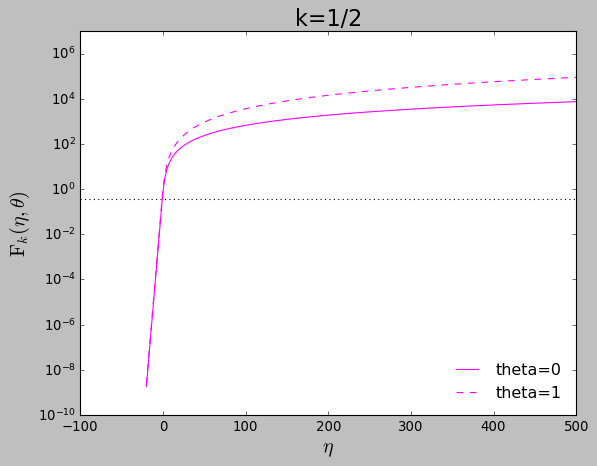

In [13]:
# simplifying to just the code that works (scipy.integrate.quad):

def quad_fdk(k, eta):
    r = quad(lambda x: (x)**(k)/(1.+np.exp(x-eta)),
            0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    return r[0], r[1]

def quad_gfdk(k, eta, theta):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        def func(x):
            return (x)**(k)*np.sqrt(1+theta*x/2.)/(1.+np.exp(x-eta))
    r = quad(func, 0, np.inf,epsabs=1e-300,epsrel=1e-8,limit=100)
    return r[0], r[1]

eta = np.linspace(-20,500,1000)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    quad_vals_theta0 = [quad_fdk(0.5, x)[0] for x in eta]
    quad_vals_theta1 = [quad_gfdk(0.5, x, 1)[0] for x in eta]

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(eta,quad_vals_theta0,color='#FF00FF',ls='-',label='theta=0')
ax.plot(eta,quad_vals_theta1,color='#FF00FF',ls='--',label='theta=1')
ax.set_yscale('log')
ax.set_ylim(1.e-10,1.e7)
ax.set_title('k=1/2',fontsize=20)
ax.legend(loc='lower right',frameon=False)
ax.set_xlabel(r"$\eta$",fontsize=18)
ax.set_ylabel(r"$\mathrm{F}_k(\eta,\theta)$",fontsize=18)
ax.axhline(0.35,color='k',ls=':')
plt.show()

In [5]:
# so we want to solve for the value of eta such that
# F(eta, theta) = (n_e * h**3)/(4*np.pi*(2*m_e*k_B*T)**(3./2.))
# where theta = (k_B*T)/(m_e * c**2)

In [10]:
n_e_med = 6.022282445046672e+22 #e-/cm^3
h = 6.62607015e-27 # erg/s
m_e = 9.1093837015e-28 #g
c = 2.99792458e10 #cm/s
kB = 1.380649e-16 #erg/K
T_med = 1.e5 #K

theta_med = (kB*T_med)/(m_e*c**2)
print(theta_med)

#rhs = (n_e_med * h**3)/(4*np.pi*(2*m_e*kB*T_med)**(3./2.))
#print(rhs)

rhs = 1.e11

1.6863700526605512e-05


In [11]:
def fdint_abs_diff(eta_test, fdint_to_match):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fdint_test = quad_gfdk(0.5, eta_test, theta_med)[0]
    return np.abs(fdint_to_match - fdint_test)

def solve_fdint(rhs, eta0 = -0.01):
    opt = optimize.minimize(fdint_abs_diff, x0=eta0, args=(rhs), bounds=[(-20.,20.)],tol=1.e-10)
    opt_eta = opt.x[0]
    return opt_eta

In [12]:
opt_eta_ = solve_fdint(rhs=rhs,eta0=)
print(opt_eta_)

print(quad_gfdk(0.5,opt_eta_,theta_med))

rel_err = np.abs(rhs - quad_gfdk(0.5,opt_eta_,theta_med)[0])/rhs
print(rel_err)

-0.01
(0.6727547632892438, 8.727076838965786e-10)
0.9999999999932724


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_33114/3925920192.py:12: RuntimeWarning: overflow encountered in exp
  return (x)**(k)*np.sqrt(1+theta*x/2.)/(1.+np.exp(x-eta))
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_33114/3925920192.py:12: RuntimeWarning: overflow encountered in exp
  return (x)**(k)*np.sqrt(1+theta*x/2.)/(1.+np.exp(x-eta))
